# Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import torch.nn  as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
import random
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

# Model

In [2]:
class aMeijerNet(nn.Module):
  def __init__(self):
    super(aMeijerNet, self).__init__()
    # input layer - 288x288x3
    # convolution layer - kernel 5x5 depth 32 ELU activation
    self.conv = nn.Conv2d(3, 32, kernel_size = 5, padding=2)
    self.elu = nn.ELU()
    # pooling layer - kernel 2x2 stride 2x2
    self.pool = nn.MaxPool2d(kernel_size = 2, padding=1)

    # convolution layer 2 - kernel 5x5 depth 32 ELU activation
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu2 = nn.ELU()
    # pooling layer 2 - kernel 2x2 stride 2x2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # convulation layer 3 - kernel 5x5 depth 32 ELU activation
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu3 = nn.ELU()
    # pooling layer 3 - kernel 2x2 stride 2x2
    self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

    # dense layer
    self.fc1 = nn.Linear(36, 512) # 32, 36, 36 -> 32, 36, 512
    # ELU activation
    self.elu4 = nn.ELU()
    # 50% dropout
    self.do1 = nn.Dropout2d(p=0.2)

    # dense layer 32, 36, 512
    self.fc2 = nn.Linear(512, 512)

    # ELU activation
    self.elu5 = nn.ELU()

    # 50% dropout
    self.do2 = nn.Dropout2d(p=0.2)

    # dense layer 32, 36, 512
    self.fc3 = nn.Linear(512, 512)

    # ELU activation
    self.elu6 = nn.ELU()

    # 50% dropout
    self.do3 = nn.Dropout2d(p=0.2)

    # output layer - 3 outputs (defect, cracks, LRCs) - sigmoid and round for each output, binary step function, etc.
    self.out = nn.Linear(294912, 3)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
   # x = torch.transpose(x, 1, 0)
    c = self.conv(x)
    e = self.elu(c)
    p = self.pool(e)

    c2 = self.conv2(p)
    e2 = self.elu2(c2)
    p2 = self.pool2(e2)

    c3 = self.conv3(p2)
    e3 = self.elu3(c3)
    p3 = self.pool3(e3)

    fc1 = self.fc1(p3)
    e4 = self.elu4(fc1)
    do1 = self.do1(e4)

    fc2 = self.fc2(do1)
    e5 = self.elu5(fc2)
    do2 = self.do2(e5)

    fc3 = self.fc3(do2)
    e6 = self.elu6(fc3)
    do3 = self.do3(e6)

    out = self.sigm(self.out(torch.flatten(do3, start_dim=1, end_dim=-1)))
    #outNum = torch.round(out, decimals=0)

    return out#outNum

# net = aMeijerNet()
# print(net(torch.from_numpy(imArr)))

# Dataset & Train/Validation

In [3]:
# load data
from PIL import Image
import numpy as np
import os
# rescale images to 288x288 (compression is better than expansion) - MAKE FUNCTION
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class SewerDataset(Dataset):
    def __init__(self, datalocations, desiredW=288, desiredH=288):
        self.datalocations = datalocations
        self.channels, self.desiredW, self.desiredH = 3, desiredW, desiredH

    def getArray(self, file, plot=False):
        im = Image.open(f"{file}")
        if plot:
            im
        w, h = im.size
        rw, rh = (self.desiredW/w, self.desiredH/h)
        imRsz = im.resize((int(im.width * rw), int(im.height * rh)), resample=1)
        imArr = np.array(imRsz, dtype=np.float32).transpose((2, 0, 1)) # transpose inputs Cin, Hin, Win
        return imArr

    def __getitem__(self, index):
        self.arr = np.zeros((self.channels, self.desiredW, self.desiredH))
        if index == 0:
            self.arr = self.getArray(self.datalocations[index], True)
        else:
            self.arr = self.getArray(self.datalocations[index])
        label = np.array([int(self.datalocations[index][-7]),
                 int(self.datalocations[index][-6]),
                 int(self.datalocations[index][-5])])
        return self.arr, label

    def __len__(self):
        return len(self.datalocations)
    # 75% training, 15% for test, 10% validation

datalocation = "/content/drive/MyDrive/ENGG-680-ProjectDataDestination/"
pre = "/content/drive/MyDrive/ENGG-680-Project/"
files = list(set(os.listdir(datalocation)) - {'desktop.ini', 'whatever.ini'})
files = [datalocation+file for file in files]
saveFiles = f"{pre}model/saved/"

_, _, filesTrain, filesTest = train_test_split(files, files, test_size=0.25, random_state=55)
_, _, filesTest, filesVal = train_test_split(filesTest, filesTest, test_size=10/25, random_state=55)

trainSet = SewerDataset(filesTrain)
valSet = SewerDataset(filesVal)
criterion = nn.BCELoss()
trainLoader = DataLoader(dataset=trainSet, batch_size=64)
valLoader = DataLoader(dataset=valSet, batch_size=64)
learningRates = [.01, .05, .001, .005] + [.0001, .0005]  # last is 5
learningRates.sort()
print(learningRates)
trainErr = torch.zeros(len(learningRates))
valErr = torch.zeros(len(learningRates))
Models = {}
epochs = 1
learningRateLosses = []
# for i, lr in enumerate(learningRates):
#     net = aMeijerNet()
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#     for epoch in range(epochs):
#         for x, y in trainLoader:
#             yHat = net(x)
#             loss = criterion(yHat, y.to(torch.float32))
#             print(f"Learning rate: {lr}; epoch: {epoch}; loss: {loss}.")
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#         torch.save(net, f"{saveFiles}net_{str(lr).replace('.', '_')}_{epoch}.pth")
#     for x, y in trainLoader:
#         # training data
#         yhat = net(x)
#         trainLoss = criterion (yhat, y.to(torch.float32))
#         trainErr[i] = trainLoss.item()
#     net = torch.load(f"{saveFiles}net_{str(lr).replace('.', '_')}_{epochs-1}.pth")
#     print(f"{str(lr).replace('.', '_')} network loaded.")
#     losses=[]
#     with torch.no_grad():
#       for idx, (x, y) in enumerate(valLoader):
#           print(x.shape)
#           # validation data
#           yhat = net(x)
#           valLoss = criterion(yhat, y.to(torch.float32))
#           valErr[i] = valLoss.item()
#           losses.append(valLoss)
#           print(f"Loss {idx+1}: {valLoss}")
#       learningRateLosses.append(losses)

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]


In [10]:
lrLossesArray = np.array(learningRateLosses)
lrLossesMean = np.mean(lrLossesArray, axis=1)
print(lrLossesArray.shape, lrLossesMean.shape)

(6, 14) (6,)


# Hyperparameter Selection (Learning Rate)

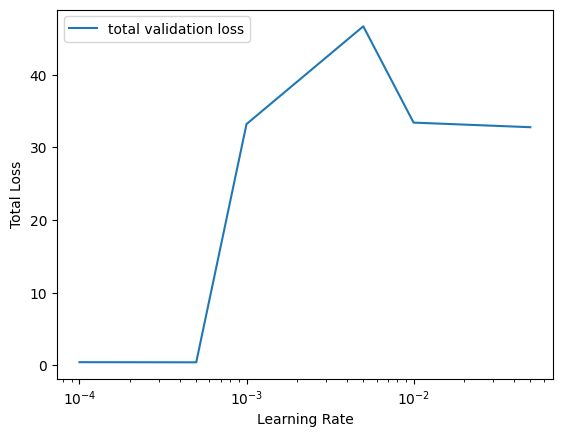

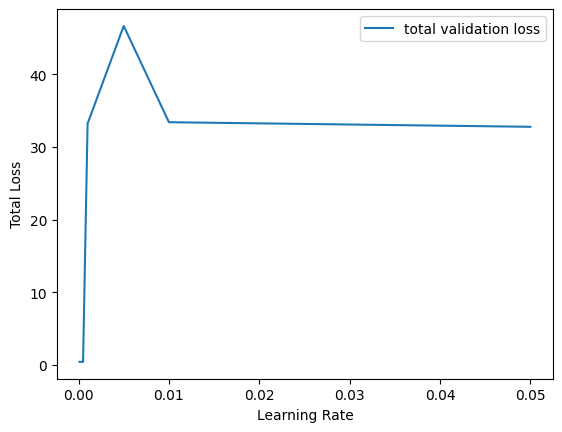

In [4]:
#plt.semilogx(np.array(learning_rates), trainErr.numpy(), label="total training loss")
saveFigsFiles = f"{pre}figures/"
learningRates = np.load(f"{saveFigsFiles}learningRates.npy")
lrLossesMean = np.load(f"{saveFigsFiles}lrLossesMean.npy")
# with open(f"{saveFigsFiles}learningRates.npy", "wb") as f:
#     np.save(f, np.array(learningRates))

# with open(f"{saveFigsFiles}lrLossesMean.npy", "wb") as f:
#     np.save(f, lrLossesMean)

plt.semilogx(learningRates, lrLossesMean, label="total validation loss")
plt.ylabel("Total Loss")
plt.xlabel("Learning Rate")
plt.legend()
plt.savefig(f"{saveFigsFiles}validation.png")
plt.show()

plt.plot(learningRates, lrLossesMean, label="total validation loss")
plt.ylabel("Total Loss")
plt.xlabel("Learning Rate")
plt.legend()
plt.savefig(f"{saveFigsFiles}validation-semilog.png")
plt.show()

# we are looking for precision/recall given imbalanced dataset

# for net, lr in zip(Models, learningRates):
#     yhat = net(valSet.x)
#     plt.plot(valSet.x.numpy(), yhat.detach().numpy(), label=f"learning rate {str(lr)}")
# plt.plot(valSet.x.numpy(), valSet.func.numpy())

# Complete Training

In [13]:
learningRate = 0.0005
epochs=1
net = torch.load(f"{saveFiles}net_{str(learningRate).replace('.', '_')}_{epochs-1}.pth")#, map_location ="cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to("cuda:0")
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
maxEpochs = 100
for epoch in range(epochs, maxEpochs):
    for x, y in trainLoader:
        x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        yHat = net(x)
        loss = criterion(yHat, y.to(torch.float32))
        print(f"Learning rate: {learningRate}; epoch: {epoch}; loss: {loss}.")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch>=80: torch.save(net, f"{saveFiles}finalForty/net_{str(learningRate).replace('.', '_')}_{epoch}.pth")


<ipython-input-13-e9e261c3018f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}net_{str(learningRate).replace('.', '_')}_{epochs-1}.pth")#, m

Streaming output truncated to the last 5000 lines.
Learning rate: 0.0005; epoch: 51; loss: 0.32666125893592834.
Learning rate: 0.0005; epoch: 51; loss: 0.11836590617895126.
Learning rate: 0.0005; epoch: 51; loss: 0.11290961503982544.
Learning rate: 0.0005; epoch: 51; loss: 0.15674147009849548.
Learning rate: 0.0005; epoch: 51; loss: 0.20513038337230682.
Learning rate: 0.0005; epoch: 51; loss: 0.12848779559135437.
Learning rate: 0.0005; epoch: 51; loss: 0.021583549678325653.
Learning rate: 0.0005; epoch: 51; loss: 0.15656794607639313.
Learning rate: 0.0005; epoch: 52; loss: 0.06900446861982346.
Learning rate: 0.0005; epoch: 52; loss: 0.09069492667913437.
Learning rate: 0.0005; epoch: 52; loss: 0.20104965567588806.
Learning rate: 0.0005; epoch: 52; loss: 0.05817723274230957.
Learning rate: 0.0005; epoch: 52; loss: 0.24487046897411346.
Learning rate: 0.0005; epoch: 52; loss: 0.2172020971775055.
Learning rate: 0.0005; epoch: 52; loss: 0.03779556602239609.
Learning rate: 0.0005; epoch: 52; 

# Hyperparameter Selection (Epoch)

In [16]:
valErrEpoch = []
epochFileNames = []

for epochFile in os.listdir(f"{saveFiles}finalForty/"):
  netEval = torch.load(f"{saveFiles}finalForty/{epochFile}")#, map_location ="cpu")
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  net.to("cuda:0")
  valLosses = []
  for i, (x, y) in enumerate(valLoader):
      # training data
      x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32) #?
      yhat = netEval(x)
      valLoss = criterion(yhat, y.to(torch.float32))
      valLosses.append(valLoss.item())
  valErrEpoch.append(valLosses)
  epochFileNames.append(epochFile)
valErrEpoch = np.array(valErrEpoch)

<ipython-input-16-94bd78edff73>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netEval = torch.load(f"{saveFiles}finalForty/{epochFile}")#, map_location ="cpu")


NameError: name 'epochFileNames' is not defined

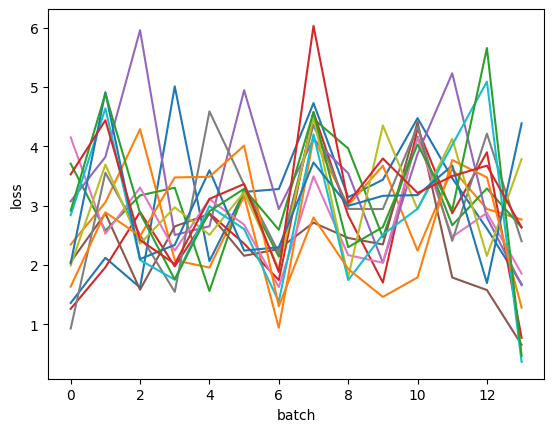

In [8]:
# with open(f"{saveFigsFiles}epochSelectionValidation.npy", "wb") as f:
#     np.save(f, valErrEpoch)
valErrEpoch=np.load(f"{saveFigsFiles}epochSelectionValidation.npy")
nfiles = valErrEpoch.shape[0]
nbatches = valErrEpoch.shape[1]

for i in range(nbatches):
  plt.plot(list(range(nbatches)), valErrEpoch[i,:])

plt.xlabel("batch")
plt.ylabel("loss")
plt.legend(epochFileNames)
plt.title("Training Loss")
#plt.savefig(f"{saveFigsFiles}epochSelectionValidation.png")
plt.show()

minIndex = np.argmin(np.mean(valErrEpoch, axis=1))
bestFile = epochFileNames[minIndex]
print(f"The best epoch index is {minIndex} and network is {bestFile}.")

# Testing

In [5]:
testSet = SewerDataset(filesTest)
learningRate = .0005
nTest = len(filesTest)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bestFile="net_0_0005_85.pth"

net = torch.load(f"{saveFiles}finalForty/{bestFile}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to("cuda:0")
predictionsCrack = np.zeros(nTest, )
predictionsLrc = np.zeros(nTest, )
predictionsDefect = np.zeros(nTest, )
actualCrack, actualLrc, actualDefect = np.zeros(nTest, ), np.zeros(nTest, ), np.zeros(nTest, )
testLoader = DataLoader(dataset=testSet, batch_size=1)
for i, (x, y) in enumerate(testLoader):
  x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32) #?
  predictions = net(x)
  predictions = torch.round(predictions, decimals=0) # rounding probability outputs?
  predictions = predictions.to("cpu").detach().numpy()
  predictions = predictions.reshape(-1,)
  predictionsCrack[i] = predictions[0]
  predictionsLrc[i] = predictions[1]
  predictionsDefect[i] = predictions[2]

  actualCrack[i] = y.to("cpu").detach().numpy().reshape(-1,)[0]
  actualLrc[i] = y.to("cpu").detach().numpy().reshape(-1,)[1]
  actualDefect[i] = y.to("cpu").detach().numpy().reshape(-1,)[2]

<ipython-input-5-962b0e60bd58>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(f"{saveFiles}finalForty/{bestFile}")


In [6]:
print(f"For cracks: {classification_report(actualCrack, predictionsCrack)}\n{confusion_matrix(actualCrack, predictionsCrack)}.\n")
print(f"For LRC: {classification_report(actualLrc, predictionsLrc)}\n{confusion_matrix(actualLrc, predictionsLrc)}.\n")
print(f"For defect: {classification_report(actualDefect, predictionsDefect)}\n{confusion_matrix(actualDefect, predictionsDefect)}.")

For cracks:               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1008
         1.0       0.85      0.89      0.87       319

    accuracy                           0.94      1327
   macro avg       0.91      0.92      0.91      1327
weighted avg       0.94      0.94      0.94      1327

[[956  52]
 [ 34 285]].

For LRC:               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1027
         1.0       0.88      0.90      0.89       300

    accuracy                           0.95      1327
   macro avg       0.93      0.93      0.93      1327
weighted avg       0.95      0.95      0.95      1327

[[992  35]
 [ 31 269]].

For defect:               precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       709
         1.0       0.97      0.91      0.94       618

    accuracy                           0.94      1327
   macro avg       0.95      0.94      0.94  

In [7]:
# with open(f"{saveFigsFiles}actualCrack.npy", "wb") as f:
#     np.save(f, actualCrack)
# with open(f"{saveFigsFiles}predictionsCrack.npy", "wb") as f:
#     np.save(f, predictionsCrack)
# with open(f"{saveFigsFiles}actualLrc.npy", "wb") as f:
#     np.save(f, actualLrc)
# with open(f"{saveFigsFiles}predictionsLrc.npy", "wb") as f:
#     np.save(f, predictionsLrc)
# with open(f"{saveFigsFiles}actualDefect.npy", "wb") as f:
#     np.save(f, actualDefect)
# with open(f"{saveFigsFiles}predictionsDefect.npy", "wb") as f:
#     np.save(f, predictionsDefect)

actualCrack=np.load(f"{saveFigsFiles}actualCrack.npy")
predictionsCrack=np.load(f"{saveFigsFiles}predictionsCrack.npy")
actualLrc=np.load(f"{saveFigsFiles}actualLrc.npy")
predictionsLrc=np.load(f"{saveFigsFiles}predictionsLrc.npy")
actualDefect=np.load(f"{saveFigsFiles}actualDefect.npy")
predictionsDefect=np.load(f"{saveFigsFiles}predictionsDefect.npy")

In [8]:
def PRAUC(ytrue, ypred, saveFigsFiles, saveFigName):
  # calculate roc curve for model
  precision, recall, _ = precision_recall_curve(ytrue, ypred)
  # plot model roc curve
  plt.plot(precision, recall, marker='.', label="pr-auc curve")
  # axis labels
  plt.xlabel('precision')
  plt.ylabel('recall')
  # show the legend
  plt.legend()
  # show the plot
  plt.savefig(f"{saveFigsFiles}{saveFigName}")
  plt.show()

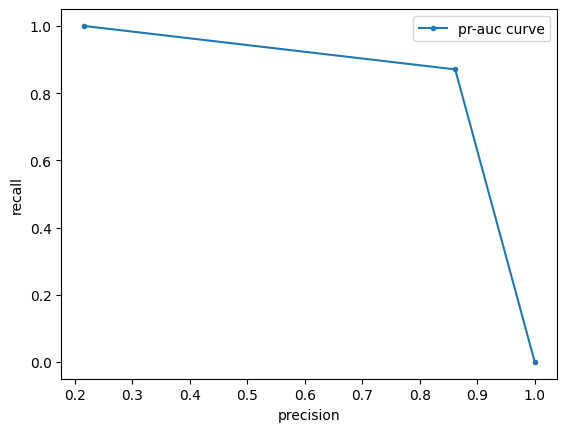

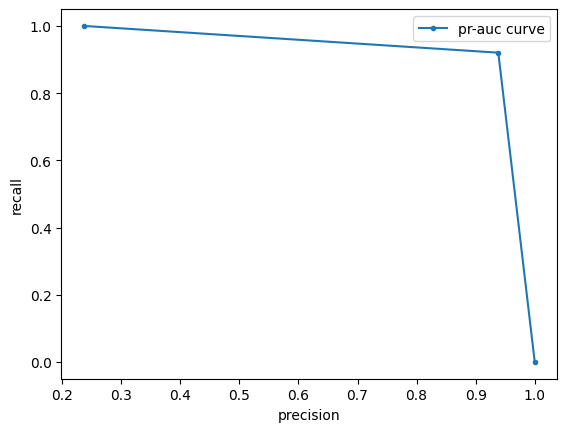

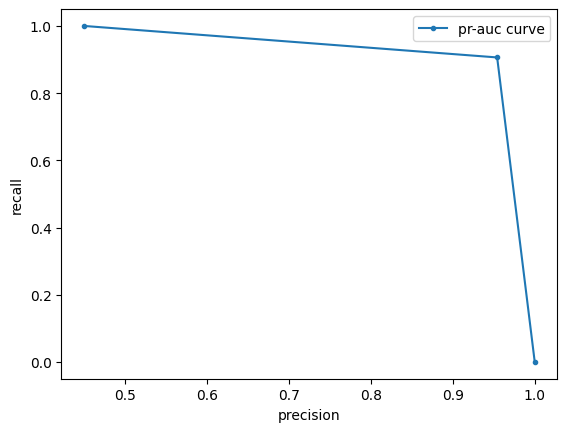

In [9]:
PRAUC(actualCrack, predictionsCrack, saveFigsFiles, "prauc_crack.png")
PRAUC(actualLrc, predictionsLrc, saveFigsFiles, "prauc_lrc.png")
PRAUC(actualDefect, predictionsDefect, saveFigsFiles, "prauc_defect.png")

# Data Analysis


In [ ]:
len(filesTrain), len(filesTest), len(filesVal)

In [ ]:
# fset = set(files)
# pre = "C:/Users/Daniel Polania/OneDrive - University of Calgary/ENGG-680-Project/data/"
# filenames = pd.read_excel(f"{pre}Combined excel.xlsx", usecols="A,B,C,D,R,U,V")
# filenames = filenames.set_index("Filename")
# import os

# for file in fset:
#     attrib = file.split("_")
#     name = attrib[0]+".png"
#     OSvalue = filenames.loc[name, "OS"]
#     newattrib = attrib[0] +"_"+ attrib[1] +"_"+ attrib[2][0] + str(OSvalue) + attrib[2][2:]
#     os.rename(f"{datalocation}{file}", f"{datalocation}{newattrib}")

# print("Done rename.")


In [ ]:
fileLabels = {}
for file in files:
    attrib = file.split("_")
    fileLabels[file] = {"va":attrib[1], "defectLabel":attrib[2][2], "crackLabel":attrib[2][0],  "lrcLabel":attrib[2][1]}
fileLabels

In [ ]:
df = pd.DataFrame.from_dict(fileLabels, orient='index')
df.head()
df["defectLabel"] = df.defectLabel.astype(np.uint16)
df["crackLabel"] = df.crackLabel.astype(np.uint16)
df["lrcLabel"] = df.lrcLabel.astype(np.uint16)
df["va"] = df.lrcLabel.astype(np.float32)

In [ ]:
describeDefects = df.defectLabel.value_counts()
describeDefects
plt.pie(describeDefects, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("Defect Distribution")
plt.savefig(figuresPrefix+"defectDistribution.png")
plt.show()

describeCracks = df.crackLabel.value_counts()
describeCracks
plt.pie(describeCracks, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("Crack Distribution")
plt.savefig(figuresPrefix+"crackDistribution.png")
plt.show()

describeLatcut = df.lrcLabel.value_counts()
describeLatcut
plt.pie(describeLatcut, labels=[0, 1], colors=["lightcoral", "peachpuff"])
plt.title("LRC Distribution")
plt.savefig(figuresPrefix+"lrcDistribution.png")
plt.show()

In [ ]:
# set(list(df.defectLabel))
# imRsz
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

# Explainability
[Grad-Cam+](https://github.com/jacobgil/pytorch-grad-cam/blob/master/README.md)

In [44]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=f5f850865ace23ddac0a2d0c81758fb07ceccb6f8cf448c825662b62809b0dc8
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [10]:
xGUICAM, yGUICAM = [], []
count = 0
for i, (x, y) in enumerate(testLoader):
  print(f"Current count at {count}.")
  if y[0][2] != 0 and count != 15:
    xGUICAM.append(x)
    yGUICAM.append(y)
    count += 1
  elif y[0][2] == 0 and count < 30:
    xGUICAM.append(x)
    yGUICAM.append(y)
    count += 1
  elif count >= 30:
    print("Got the 30 examples.")
    break
  else:
    continue

Current count at 0.
Current count at 1.
Current count at 2.
Current count at 3.
Current count at 4.
Current count at 5.
Current count at 6.
Current count at 7.
Current count at 8.
Current count at 9.
Current count at 10.
Current count at 11.
Current count at 12.
Current count at 13.
Current count at 14.
Current count at 15.
Current count at 16.
Current count at 17.
Current count at 18.
Current count at 19.
Current count at 20.
Current count at 21.
Current count at 22.
Current count at 23.
Current count at 24.
Current count at 25.
Current count at 26.
Current count at 27.
Current count at 28.
Current count at 29.
Current count at 30.
Got the 30 examples.


In [16]:
len(xGUICAM), len(yGUICAM)

(36, 36)

In [79]:
for x, y in zip(xGUICAM, yGUICAM):
  target_layers = [net.conv]
  input_tensor = x# Create an input tensor image for your model..
  # Note: input_tensor can be a batch tensor with several images!

  # We have to specify the target we want to generate the CAM for.
  targets = [ClassifierOutputTarget(0)]

  # Construct the CAM object once, and then re-use it on many images.
  with GradCAM(model=net, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    print(input_tensor.squeeze(0).shape)
    visualization = show_cam_on_image(input_tensor.squeeze(0), grayscale_cam, use_rgb=True)
    # You can also get the model outputs without having to redo inference
    model_outputs = cam.outputs


torch.Size([3, 288, 288])


TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


# GUI

In [21]:
# https://coordinates-converter.com/en/decimal/51.025327,-114.049868?karte=OpenStreetMap&zoom=8
# 51.113268, -114.225369 NORTH WEST
# 50.900844, -113.912041 SOUTH EAST
def getCoords(cityBoundariesDDLat=(50.900844, 51.113268), cityBoundariesDDLon=(-113.912041, -114.225369), seed=29):
  """
  """
  return random.uniform(cityBoundariesDDLat[0], cityBoundariesDDLat[1]), random.uniform(cityBoundariesDDLon[0], cityBoundariesDDLon[1])

def locate(latlon, windowSize, cityBoundariesDDLat=(50.900844, 51.113268), cityBoundariesDDLon=(-113.912041, -114.225369)):
  lat, lon = latlon
  x = (lat - cityBoundariesDDLat[0])*(windowSize[0] - 0)/(cityBoundariesDDLat[1] - cityBoundariesDDLat[0])
  y = (lon - cityBoundariesDDLon[0])*(windowSize[1] - 0)/(cityBoundariesDDLon[1] - cityBoundariesDDLon[0])
  return x, y

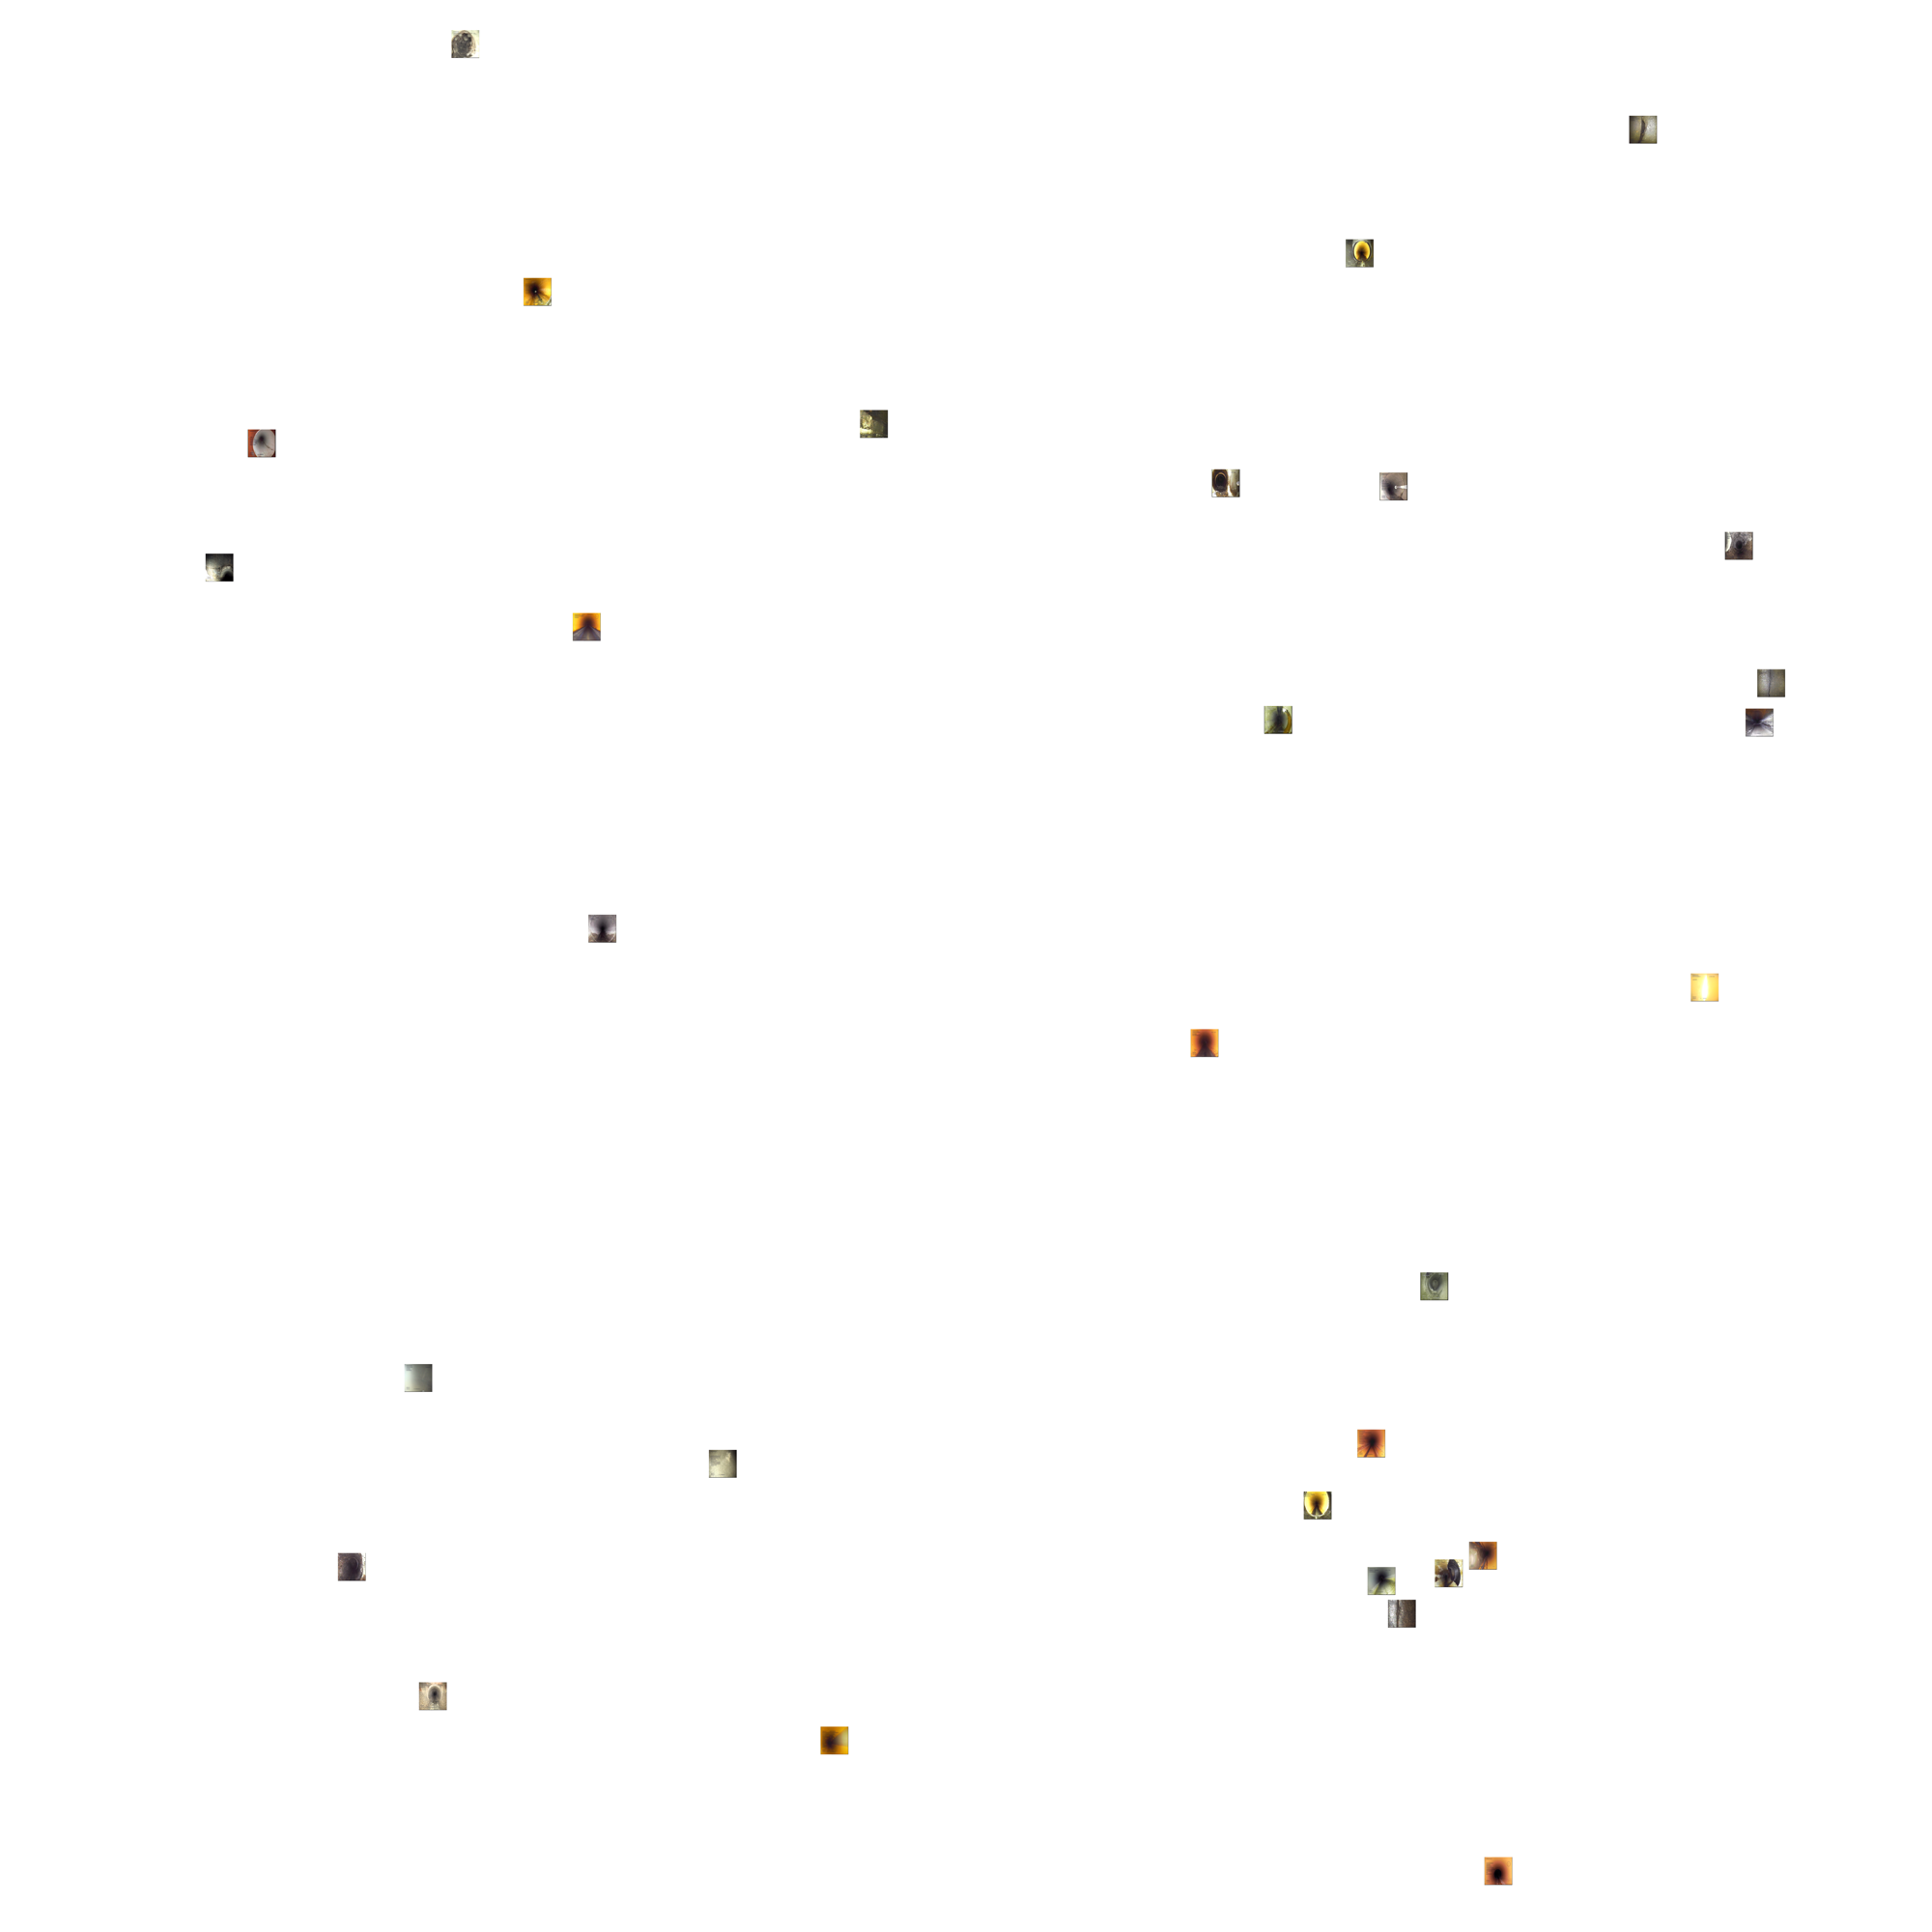

In [25]:
windowSize=(1000*20+20, 1000*20+20, 3)
window = np.ones(windowSize)
for x, y in zip(xGUICAM, yGUICAM):
  arr = x.squeeze(0).to("cpu").detach().numpy().transpose(1,2,0)
  image = Image.fromarray((arr * 255).astype(np.uint8))
  arr288 = np.array(image)
  # image = ImageTk.PhotoImage(image)
  coords = getCoords()
  xPlace, yPlace = locate(coords, windowSize)
  xPlace, yPlace = int(xPlace), int(yPlace)
  window[xPlace:xPlace+288, yPlace:yPlace+288, :] = arr288
GUI = Image.fromarray((window * 255).astype(np.uint8))
GUI = GUI.resize((2000, 2000))
GUI

[Tkinter in Colab](https://stackoverflow.com/questions/61168210/is-there-any-way-to-use-tkinter-with-google-colaboratory)